# Importing Libraries and Pre-Processing

In [1]:
### Importing Libraries
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libraries
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

# Preprocessing and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold

# Model saving
import pickle

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import Normalize

import timeit
from datetime import timedelta

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
### Importing and Preparing Data
# load dataset
full_train_data = pd.read_csv('train_x.csv').to_numpy()
full_train_label = pd.read_csv('train_y.csv').to_numpy().flatten()
test_data = pd.read_csv('test_x.csv').to_numpy()
test_label = pd.read_csv("test_y.csv").to_numpy().flatten()

print(f'Full train data: X = {full_train_data.shape}, y = {full_train_label.shape}')
print(f'Full test data:  X = {test_data.shape}, y = {test_label.shape}')

Full train data: X = (50000, 3072), y = (50000,)
Full test data:  X = (10000, 3072), y = (10000,)


In [3]:
# Training and Validation Set Split
train_data, val_data, train_label, val_label = train_test_split(
    full_train_data, full_train_label, test_size = 0.3, 
    stratify = full_train_label, random_state = 40)
print(f'Train data:       X = {train_data.shape}, y = {train_label.shape}')
print(f'Validation data:  X = {val_data.shape}, y = {val_label.shape}')

Train data:       X = (35000, 3072), y = (35000,)
Validation data:  X = (15000, 3072), y = (15000,)


In [4]:
# Dimensionality Reduction - PCA
pca_scaled = make_pipeline(StandardScaler(), 
                           PCA(n_components=0.8, whiten=True, random_state=0))
X_train_pca = pca_scaled.fit_transform(train_data)
X_val_pca = pca_scaled.transform(val_data)
print("PCA train data shape:      {}".format(X_train_pca.shape))
print("PCA validation data shape: {}".format(X_val_pca.shape))

PCA train data shape:      (35000, 34)
PCA validation data shape: (15000, 34)


In [5]:
# Histogram of Oriented Gradients
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

def extract_hog(data):
    fd_array = np.empty(shape=(len(data), 3780), dtype='float')
    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd = hog(resized_img, orientations=9, pixels_per_cell=(8,8), 
                 cells_per_block=(2,2), transform_sqrt=True, block_norm="L1")
        fd_array[i] = fd
    return fd_array

In [6]:
X_train_hog = extract_hog(train_data)
X_val_hog = extract_hog(val_data)

In [7]:
X_full_train_hog = extract_hog(full_train_data)

In [8]:
# Dimensionality Reduction - HOG-PCA
pca_scaled2 = make_pipeline(StandardScaler(), 
                           PCA(n_components=150, whiten=False, random_state=0))
X_train_hg = pca_scaled2.fit_transform(X_train_hog)
X_val_hg = pca_scaled2.transform(X_val_hog)
print("PCA train data shape:      {}".format(X_train_hg.shape))
print("PCA validation data shape: {}".format(X_val_hg.shape))

PCA train data shape:      (42500, 150)
PCA validation data shape: (7500, 150)


# Classification

### Gradient Boosting

In [5]:
# Random Search with several parameters using training data
max_iter = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
learning_rate = [0.1, 0.2, 0.3]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
l2_regularization = [int(x) for x in np.linspace(1, 2, num = 11)]
parameters = {
 'max_iter': max_iter,
 'learning_rate': learning_rate,
 'max_depth' : max_depth,
 'l2_regularization': l2_regularization
 }

In [6]:
hgbr = HistGradientBoostingClassifier()
hgb_random = RandomizedSearchCV(
    estimator = hgbr, param_distributions = parameters, 
    n_iter = 10, cv = 4, verbose = 2, random_state = 32, n_jobs = -1)
tic = timeit.default_timer()
hgb_random.fit(X_train_pca, train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 17.1min finished


time elapsed: 0:24:22.379787


In [7]:
hgb_results = pd.DataFrame(hgb_random.cv_results_)
print(hgb_random.best_params_)
print(hgb_random.best_score_)                  # 0.5147529411764706 0.5061142857142857
print(hgb_random.score(X_val_pca, val_label))  # 0.5292             0.5204
# {'max_iter': 2000, 'max_depth': 10, 'learning_rate': 0.1, 'l2_regularization': 1}

{'max_iter': 2000, 'max_depth': 10, 'learning_rate': 0.1, 'l2_regularization': 1}
0.5061142857142857
0.5204


In [8]:
# Building a model with all the training and validation data and testing with test data
pca_pipe = make_pipeline(StandardScaler(), 
                           PCA(n_components=0.8, whiten=True, random_state=0))
xgbmod = HistGradientBoostingClassifier(l2_regularization = 1, learning_rate = 0.1,
                                       max_iter = 2000, max_depth = 10)
xgb_pipe = make_pipeline(pca_pipe, xgbmod)
tic = timeit.default_timer()
xgb_pipe.fit(full_train_data, full_train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}") # 1149.32 seconds

time elapsed: 0:10:03.546192


In [9]:
print(f"Train accuracy: {xgb_pipe.score(full_train_data, full_train_label)}") # 1
print(f"Test accuracy:  {xgb_pipe.score(test_data, test_label)}")             # 0.5647

Train accuracy: 1.0
Test accuracy:  0.5337


In [10]:
# Model prediction
pred = xgb_pipe.predict(test_data)

Accuracy: 0.534
Confusion matrix:
[[614  39  54  27  30  12  24  31 117  52]
 [ 35 641  10  22  13  22  24  26  57 150]
 [ 82  32 413  87 115  63 104  51  34  19]
 [ 30  36  80 334  60 219 107  60  25  49]
 [ 43  15 118  73 455  59 110  79  27  21]
 [ 19  14  68 210  43 425  83  83  28  27]
 [ 11  26  70  69  86  48 623  30  12  25]
 [ 33  23  42  60  68  74  53 567  17  63]
 [ 79  64  18  25  15  19  11  22 683  64]
 [ 38 158   9  41  12  24  16  43  77 582]]


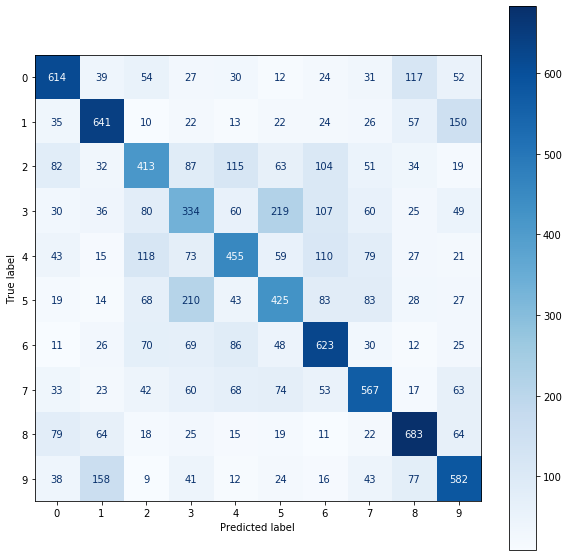

In [11]:
print(f"Accuracy: {accuracy_score(test_label, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(test_label, pred)}")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix(test_label, pred), 
                       display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']).plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
plt.savefig("confusion_xgb.png")

In [12]:
# Classification report
print(classification_report(test_label, pred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62      1000
           1       0.61      0.64      0.63      1000
           2       0.47      0.41      0.44      1000
           3       0.35      0.33      0.34      1000
           4       0.51      0.46      0.48      1000
           5       0.44      0.42      0.43      1000
           6       0.54      0.62      0.58      1000
           7       0.57      0.57      0.57      1000
           8       0.63      0.68      0.66      1000
           9       0.55      0.58      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



In [13]:
# Save model file with pickle
xgb_pickle = "Pickle_XGB.pkl"  

with open(xgb_pickle, 'wb') as file:  
    pickle.dump(xgb_pipe, file)

In [5]:
# Load model from file with pickle
xgb_pickle = "Pickle_XGB.pkl" 
with open(xgb_pickle, 'rb') as file:  
    pickled_xgb = pickle.load(file)

pickled_xgb

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=100, random_state=0,
                                      svd_solver='auto', tol=0.0,
                                      whiten=True))],
                          verbose=False)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=1,
                                                learning_rate=0.1, loss='auto',
                                                max_bins=255, max_depth=10,
                                                max_iter=2000,
                             